### Testing Grad-CAM on CIFAR-10

In this notebook we will experiment with Grad-CAM, an introspection method for convolutional neural networks [1].
We have trained a neural network (as defined in net.py) and saved it to a file. Let's begin by loading it.

In [1]:
import torch
from net import Net

net = Net()
net.load_state_dict(torch.load('net.pt', map_location='cpu'))
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


We're also going to need the data:

In [2]:
import torchvision
import torchvision.transforms as transforms
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let's now visualize some images:

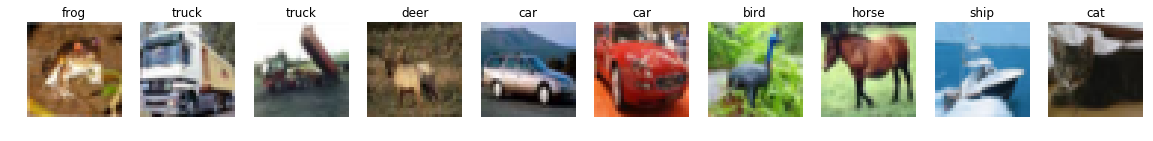

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def imshow(img, label=""):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.axis('off')

N = 10
plt.figure(figsize=(2*N, 4))
for i in range(N):
    plt.subplot(1, N, i+1)
    imshow(trainset[i][0], classes[trainset[i][1]])

Now we can make predictions with the trained network.

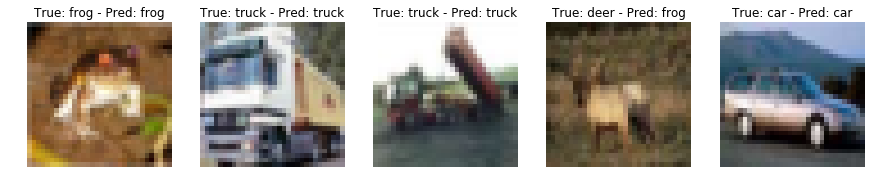

In [4]:
N = 5
plt.figure(figsize=(3*N, 4))
for i in range(N):
    plt.subplot(1, N, i+1)
    # Put a single image into a batch of size 1
    test_img = trainset[i][0].unsqueeze(dim=0)

    # Get predicted logits, argmax for index and convert to label string
    pred = classes[torch.argmax(net(test_img)[0]).item()]

    imshow(test_img[0], 'True: {:s} - Pred: {:s}'.format(classes[trainset[i][1]], pred))

Ok, so we have the data, the model, and we can make predictions. We can move to Grad-CAM. According to their method, the localization map is computed using the feature maps produced by a convolutional layer. Apparently, they use the gradient of the feature maps from the last convolutional layer. **To get the gradient of intermediate variables we need to add hooks** (see [this](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook) and [this](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94)). We could do this in the source code of the model but for simplicity we'll do it here:

In [5]:
import torch.nn.functional as F

# The hook to register, it receives the gradient
def process_fmap_grad(grad):
    print('Gradient has shape', grad.shape)

# Here we're mostly copying from the original model
def forward(self, x):
    f_map1 = self.conv1(x)
    x = self.pool(F.relu(f_map1))    
    f_map2 = self.conv2(x)    
    
    f_map2.register_hook(process_fmap_grad)
    
    x = self.pool(F.relu(f_map2))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

We can now perform a forward pass and backpropagate the gradient based on the correct class (frog). The hook will print the shape of the gradient of the feature map:

In [6]:
# Put a frog into a batch of size 1
net.zero_grad()
img = trainset[0][0].unsqueeze(dim=0)
# Forward pass, get logit
x = forward(net, img)
# Get prediction
pred_idx = torch.argmax(x[0])
pred = x[0][pred_idx]
# Backward pass
pred.backward()

Gradient has shape torch.Size([1, 16, 10, 10])


We now have the gradients of the 16 feature maps (the k-th feature map is denoted as $A^k$ in the Grad-CAM paper). Thus we have computed 
$$
\frac{\partial y^c}{\partial A^k}
$$

The next step is to compute
$$
\alpha_k^c = \frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A^k_{ij}}
$$

and
$$
L_{\text{Grad-CAM}}^c = \text{ReLU}\left( \sum_k \alpha_k^c A^k \right)
$$

These correspond to equations (1) and (2) of [1]. Calculations are implemented next:

In [7]:
from scipy.interpolate import interp2d

def process_fmap_grad(grad):
    # Extract single feature map gradient from batch
    fmap_grad = grad[0]
    # and compute global average
    a_k = fmap_grad.mean(dim=-1).mean(dim=-1)
    grad_cam = F.relu(torch.sum(a_k[:, None, None] * fmap_grad, dim=0)).data.numpy()
    
    # Use bilinear interpolation to resize to input image resolution (32x32)
    nx, ny = grad_cam.shape
    x = np.linspace(0, 32, nx, endpoint=False)
    y = np.linspace(0, 32, ny, endpoint=False)
    f = interp2d(x, y, grad_cam)
    xx = np.linspace(0, 32, 32, endpoint=False)
    yy = np.linspace(0, 32, 32, endpoint=False)
    visual = f(xx, yy)
    
    # Plot grad-cam
    cmap = matplotlib.cm.jet
    cmap._init()
    alphas = np.linspace(0, 1, cmap.N+3)
    cmap._lut[:,-1] = alphas
    plt.contourf(visual, cmap=cmap)
    
    #colors = [(1,0,0,c) for c in np.linspace(0, 1, 100)]
    #cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
    #plt.contourf(visual, cmap=cmapred)

Let's test now for 5 images:

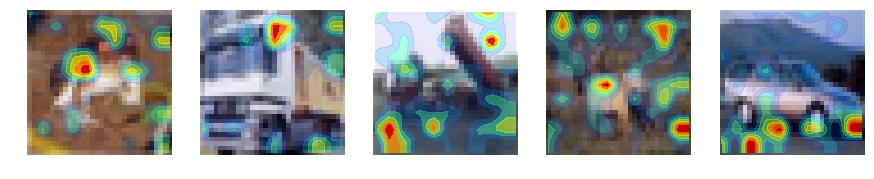

In [8]:
N = 5
plt.figure(figsize=(3*N, 4))
for i in range(5):
    net.zero_grad()
    # Put a frog into a batch of size 1
    img = trainset[i][0].unsqueeze(dim=0)
    plt.subplot(1, 5, i+1)
    imshow(img[0])

    # Forward pass, get logit
    x = forward(net, img)
    # Get prediction
    pred_idx = torch.argmax(x[0])
    pred = x[0][pred_idx]
    # Backward pass
    pred.backward()

The highlighted regions correspond to pixels whose intensity needs to be increased in order to increase the logit of the predicted class.

## References
[1] Selvaraju, R. R., Das, A., Vedantam, R., Cogswell, M., Parikh, D., & Batra, D. (2016). Grad-CAM: Why did you say that?. arXiv preprint arXiv:1611.07450.